*Load and preprocess corpus*

List of the caracters used

In [26]:

import spacy
import re
from pathlib import Path
import ftfy
import numpy as np
import sys
import glob
from PIL import Image
#!{sys.executable} -m pip install python-louvain
#!{sys.executable} -m pip install louvain
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m pip install ftfy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install Pillow
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install nltk


allnames=['Pison', 'Hiddekel', 'Adam', 'Eve', 'Cain', 'Enoch', 'Irad', 'Methusael', 'Lamech', 'Zillah', 'Seth', 'Enos', 'Methuselah', 'Noah', 'Canaan', 'Shem', 'Cush', 'Mizraim', 'Heth', 'Gether', 'Salah', 'Eber', 'Peleg', 'Jerah', 'Uzal', 'Diklah', 'Obal', 'Terah', 'Abram', 'Haran', 'Lot', 'Sarai', 'Shinab', 'Zoar', 'Dan', 'Sarah', 'Benammi', 'Nahor', 'Buz', 'Kemuel', 'Chesed', 'Jidlaph', 'Rebekah', 'Laban', 'Zimran', 'Medan', 'Jokshan', 'Sheba', 'Epher', 'Abidah', 'Isaac', 'Ishmael', 'Rachel', 'Bilhah', 'Levi', 'Jacob', 'Asher', 'Reuben', 'Zebulun', 'Dinah', 'Joseph', 'Deborah', 'Benjamin', 'Naphtali', 'Korah', 'Omar', 'Zepho', 'Zerah', 'Jaalam', 'Lotan', 'Shobal', 'Dishan', 'Samlah', 'Baalhanan', 'Mehetabel', 'Hirah', 'Onan', 'Pharez', 'Jachin', 'Shaul', 'Arodi', 'Malchiel', 'Belah', 'Jordan', 'Ephron', 'Machir', 'Abraham', 'Aaron', 'Jethro', 'Zipporah', 'Shimi', 'Elzaphan', 'Eleazar', 'Miriam', 'Hur', 'Joshua', 'Eliezer']
#allnames00000=['Nahor', 'Buz', 'Kemuel', 'Chesed', 'Jidlaph', 'Pison', 'Hiddekel', 'Adam', 'Eve', 'Cain', 'Enoch', 'Irad', 'Lamech', 'Zillah', 'Seth', 'Enos', 'Methuselah', 'Noah', 'Canaan', 'Shem', 'Cush', 'Heth', 'Gether', 'Salah', 'Peleg', 'Jerah', 'Uzal', 'Diklah', 'Obal', 'Terah', 'Abram', 'Sarai', 'Shinab', 'Zoar', 'Dan', 'Sarah', 'Benammi', 'Rebekah', 'Laban', 'Zimran', 'Medan', 'Sheba', 'Epher', 'Abidah', 'Isaac', 'Rachel', 'Bilhah', 'Levi', 'Asher', 'Reuben', 'Zebulun', 'Dinah', 'Joseph', 'Benjamin', 'Naphtali', 'Korah', 'Omar', 'Zepho', 'Zerah', 'Jaalam', 'Lotan', 'Shobal', 'Dishan', 'Samlah', 'Baalhanan', 'Mehetabel', 'Hirah', 'Onan', 'Pharez', 'Jachin', 'Shaul', 'Arodi', 'Malchiel', 'Belah', 'Jordan', 'Machir', 'Aaron', 'Jethro', 'Zipporah', 'Shimi', 'Elzaphan', 'Miriam', 'Hur', 'Joshua', 'Eliezer']
lg_allnames = len(allnames)




In [27]:
def get_index(list_name):
    """Return the list of indices, in the global list of names, of the names in list_name
    """
    list_index=[]

    for i in list_name:
        for j in range(lg_allnames):
            if(i==allnames[j]):
                list_index.append(j)

    return list_index

In [28]:
import numpy as np
def update_matrix(names, matrix_occ, matrix_diag):
    """Based on a list of names, update the matrix of occurence and the diagonal matrix
    Param
    -----------
    names : [str] List of names
    matrix_occ : [[int]] matrix containing 1 if 2 caracters been mentionned in a same verset
    matrix_diag : [[int]] matrix diagonal containing the degree of each nodes (the number of contacts with others characters)
    """
    if names:
        list_index = get_index(names)

        for i in range(len(list_index)-1):
            for j in range(i+1,len(list_index)):
                # Verify if the two characters not been mentionned in a same verset before
                if(matrix_occ[list_index[i]][list_index[j]]==0):
                    # Adding the fact that these two characters has been mentionned
                    matrix_occ[list_index[j]][list_index[i]]=1
                    matrix_occ[list_index[i]][list_index[j]]=1
                    # Add another new connection for the 2 characters
                    matrix_diag[list_index[i]][list_index[i]]+=1
                    matrix_diag[list_index[j]][list_index[j]]+=1
        
    return matrix_occ, matrix_diag

"""name_test = set(('Aaron', 'Hur', 'Benjamin'))
matrix1, matrix2 = update_matrix(name_test,np.zeros((lg_allnames,lg_allnames)), np.zeros((lg_allnames,lg_allnames)))"""


"name_test = set(('Aaron', 'Hur', 'Benjamin'))\nmatrix1, matrix2 = update_matrix(name_test,np.zeros((lg_allnames,lg_allnames)), np.zeros((lg_allnames,lg_allnames)))"

In [29]:
import nltk
def extract_names(path):
    #names_by_verset={}
    #NER = spacy.load("en_core_web_sm")
    # Load the text document in a list of verset
    doc = Path(path, encoding='cp1252').read_text(encoding='cp1252').split('\n\n')

    matrix_occ = np.zeros((lg_allnames, lg_allnames), dtype=np.int32)
    matrix_diag = np.zeros((lg_allnames,lg_allnames), dtype=np.int32)

    for i in range(len(doc)):
        # Preprocess and clean each verset
        doc[i]= re.sub(' +', ' ', ftfy.fix_text(doc[i]))
        doc[i]= re.sub('\n', ' ', doc[i])
        doc[i]= re.sub('\'', ' ', doc[i])
        verses = nltk.word_tokenize(doc[i])

        # Init the key i to get all names present in the verset ith
        names_by_verset = []
        #text1= NER(doc[i])

        # Incorpore each name once in the dictionnary at the ith position
        for word in verses:
            #if(word.label == "PERSON"):
            if(word in allnames):
                if(word not in names_by_verset):
                    names_by_verset.append(word)

        matrix_occ, matrix_diag =update_matrix(names_by_verset, matrix_occ, matrix_diag)
    return matrix_occ, matrix_diag

#matrix_occ, matrix_diag = extract_names('bible12_n.txt')

'''a_file = open("matrix_occ.txt", "w")
for row in matrix_occ:
    np.savetxt(a_file, row)

a_file.close()

b_file = open("matrix_D.txt", "w")
for row in matrix_diag:
    np.savetxt(b_file, row)

b_file.close()
'''



'a_file = open("matrix_occ.txt", "w")\nfor row in matrix_occ:\n    np.savetxt(a_file, row)\n\na_file.close()\n\nb_file = open("matrix_D.txt", "w")\nfor row in matrix_diag:\n    np.savetxt(b_file, row)\n\nb_file.close()\n'

In [30]:
matrix_occ = np.loadtxt("matrix_occ(1).txt").reshape(lg_allnames, lg_allnames)
matrix_diag = np.loadtxt("matrix_D(1).txt").reshape(lg_allnames, lg_allnames)



Plot the addition between the 2 matrix

/var/folders/gj/3zjx0x1d3x3bj6bfrlgym5fw0000gs/T/ipykernel_1034/509538541.py:15: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(matrix)


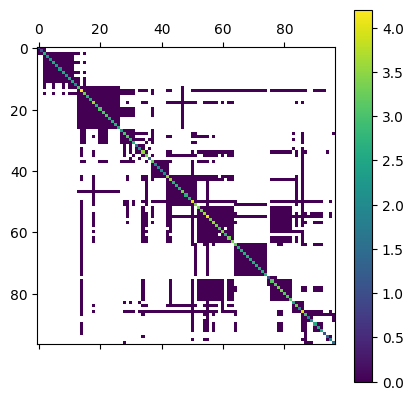

In [31]:
import matplotlib.pyplot as plt

def plot_matrix(matrix):


    for i in range (len(matrix)):
        for j in range (len(matrix)):

            if (i!=j):
                if (matrix[i][j]==0 ):
                    matrix[i][j] =1
                elif (matrix[i][j]==1 ):
                    matrix[i][j] =0

    matrix = np.log(matrix)
    plt.matshow(matrix)
    plt.colorbar()
    plt.show()

plot_matrix(matrix_diag-matrix_occ+1)

[(0, 2), (1, 2), (2, 14), (3, 9), (4, 9), (5, 12), (6, 9), (7, 9), (8, 12), (9, 9), (10, 12), (11, 12), (12, 7), (13, 20), (14, 66), (15, 26), (16, 14), (17, 14), (18, 36), (19, 14), (20, 20), (21, 20), (22, 20), (23, 14), (24, 14), (25, 14), (26, 14), (27, 10), (28, 19), (29, 21), (30, 16), (31, 14), (32, 4), (33, 8), (34, 33), (35, 26), (36, 3), (37, 24), (38, 7), (39, 7), (40, 7), (41, 7), (42, 32), (43, 36), (44, 14), (45, 14), (46, 14), (47, 27), (48, 14), (49, 14), (50, 52), (51, 29), (52, 26), (53, 26), (54, 36), (55, 56), (56, 27), (57, 34), (58, 27), (59, 21), (60, 29), (61, 15), (62, 27), (63, 27), (64, 23), (65, 13), (66, 13), (67, 13), (68, 13), (69, 13), (70, 13), (71, 13), (72, 13), (73, 13), (74, 13), (75, 2), (76, 22), (77, 22), (78, 27), (79, 27), (80, 21), (81, 21), (82, 21), (83, 11), (84, 25), (85, 7), (86, 49), (87, 19), (88, 6), (89, 7), (90, 12), (91, 12), (92, 12), (93, 2), (94, 3), (95, 6), (96, 4)]
-0.010795958540375381
[2, 2, 14, 9, 9, 12, 9, 9, 12, 9, 12, 12

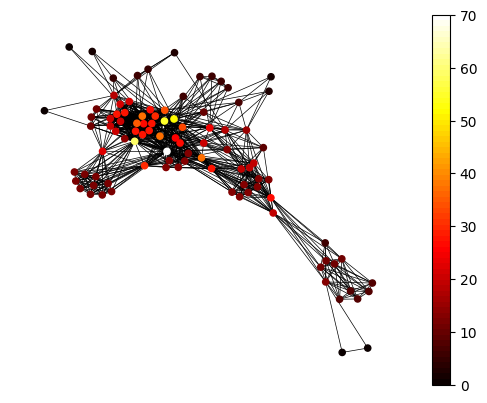

In [32]:
import networkx as nx

color_map=[]
def create_graph(matrix):
    length_Matrix = len(matrix)
    G = nx.Graph()
    G.clear()

    G.add_nodes_from([i for i in range(length_Matrix)], weight = [matrix[i][i] for i in range(length_Matrix)])

    for j in range(length_Matrix-1):
        for k in range (j+1,length_Matrix,1):
            if(matrix[j][k]!=0):
                G.add_edge(j,k)

    '''for node in G:
            if node ==13:
                color_map.append('green')
            elif node ==15:
                color_map.append('green')
            elif node ==86:
                color_map.append('purple')
            elif node == 64:
                color_map.append('red')
            else: 
                color_map.append('blue') 
'''
    return G

graph_net = create_graph(matrix_diag+matrix_occ)
print(list(graph_net.degree()))
cmap = plt.cm.get_cmap('hot', 66 + 1)
print(nx.degree_assortativity_coefficient(graph_net))
degrees= []
for i in range (len (graph_net.degree())):
    degrees.append(graph_net.degree()[i])

print(degrees)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=70))
sm._A = []
ax = plt.gca()
nx.draw(graph_net, nx.spring_layout(graph_net,seed=41),cmap=cmap, node_color=degrees, node_size=20, width=0.5)
plt.colorbar(sm, ax=ax)



average degree = 17.711340206185568


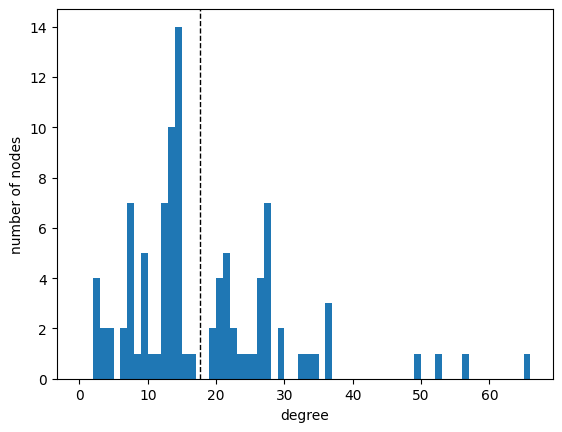

In [33]:

def display_histo(matrix):
    """Display a histo of the degree's frequencies
    """

    maximum = int(matrix.max())

    diagoV = [matrix[i][i] for i in range (len (matrix))]
    average = sum(diagoV) / len(diagoV)
    
    print("average degree = " + str (average))
    plt.hist(diagoV,bins = list(range(0,int(maximum)+1)))
    plt.axvline(average, color='k', linestyle='dashed', linewidth=1)
    plt.ylabel('number of nodes')
    plt.xlabel("degree")
    plt.show()

display_histo(matrix_diag)

In [34]:
"""!pip3 install python-louvain"""


'!pip3 install python-louvain'

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 2, 14: 3, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 4, 28: 4, 29: 4, 30: 4, 31: 4, 32: 4, 33: 4, 34: 5, 35: 1, 36: 4, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 1, 43: 5, 44: 1, 45: 1, 46: 1, 47: 2, 48: 1, 49: 1, 50: 5, 51: 3, 52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 5, 59: 5, 60: 5, 61: 5, 62: 5, 63: 5, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 69: 3, 70: 3, 71: 3, 72: 3, 73: 3, 74: 3, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 4, 84: 1, 85: 4, 86: 4, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 3, 94: 5, 95: 5, 96: 5}


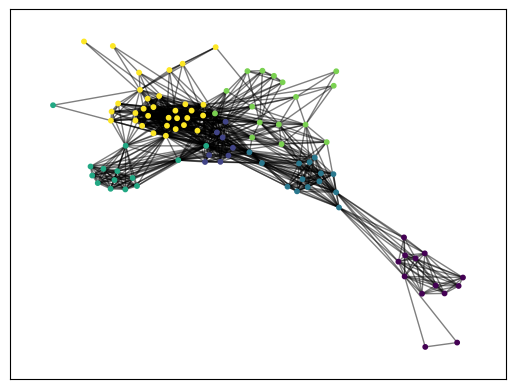

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [35, 42, 44, 45, 46, 48, 49, 84], [13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 47], [14, 51, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 93], [27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 83, 85, 86], [34, 43, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 75, 76, 77, 78, 79, 80, 81, 82, 87, 88, 89, 90, 91, 92, 94, 95, 96]]


In [35]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

partitions = []
apperance=[]
t=0
sasa=0
def louvain(G):

    partition = community_louvain.best_partition(G)
    
     
    
        
    pos = nx.spring_layout(G, seed=41)
    #color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=10,cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    print(partition)
    for i in range (max(partition.values())+1):
        partitions.append([])
        for j in range (len (partition)):
            if partition.get(j) == i:
                partitions[i].append(j)
    plt.show()


louvain(graph_net)
print(partitions)


6
Terah
Abram
Haran
Lot
Sarai
Shinab
Zoar
Benammi
Nahor
Buz
Kemuel
Chesed
Jidlaph
Jordan
Machir
Abraham


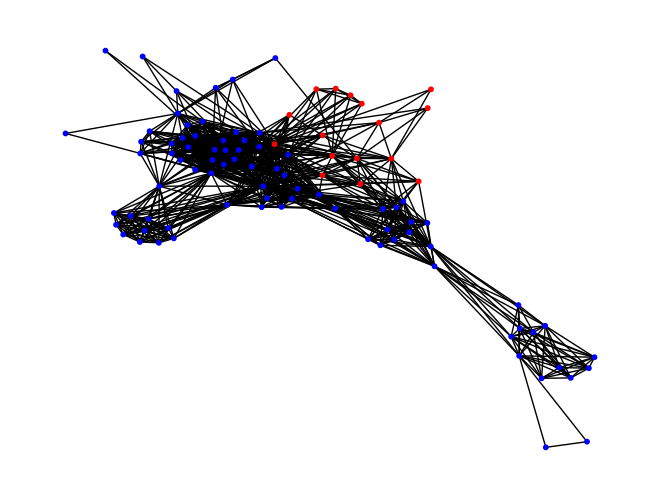

In [36]:
color_map=[]
def color_commuity(community_index):
    print(len(partitions))
    for node in graph_net:
        if node in partitions[community_index]:
            color_map.append('red')
        else:
            color_map.append('blue')
    pos = nx.spring_layout(graph_net, seed=41)

    nx.draw(graph_net,pos=pos,node_color=color_map,node_size=10)

    for i in range (len (partitions[community_index])):
        print(allnames[partitions[community_index][i]])
color_commuity(4)



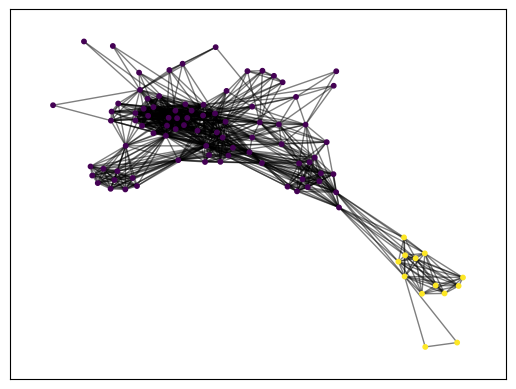

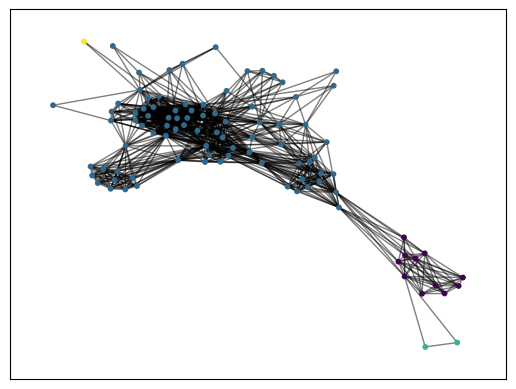

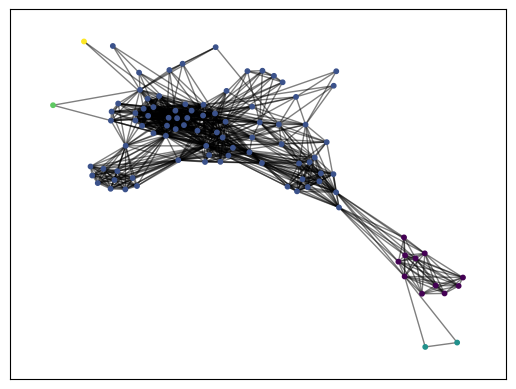

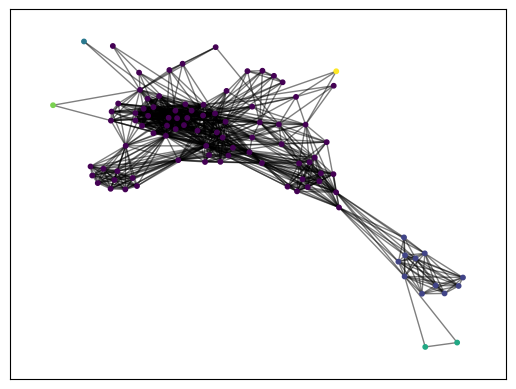

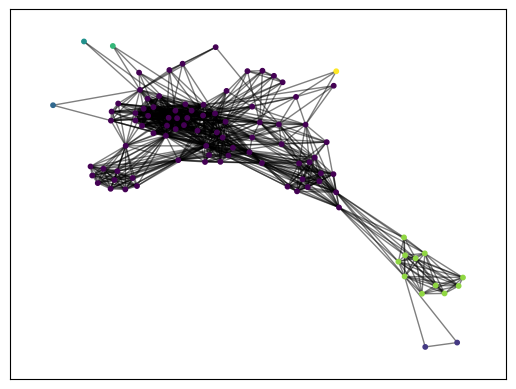

In [37]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import scipy
import matplotlib.pyplot as plt


def laplace (k):
    
    lapl_matrix = matrix_diag - matrix_occ


    L1 = lapl_matrix[0:5,0:5]
    #print(L1)
    L2 = lapl_matrix[5:18,5:18]
    #print(L2)
    L3 = lapl_matrix[18:lg_allnames, 18:lg_allnames]

    # eigenvalues and eigenvectors
    vals, vecs = scipy.linalg.eigh(lapl_matrix)
    # sort these based on the eigenvalues
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    #print(L2)
    #print(len(L2))

    """vecs[:,0] = np.full(len(L1),1)
    vals[0] = 0"""

    #print(vals)
    #print(vecs[:,1])

    # kmeans on first three vectors with nonzero eigenvalues
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    colors = kmeans.labels_

    #print("Clusters:", colors)
    
    graph_L3 = create_graph(np.abs(lapl_matrix))
    #print(L2)
    pos = nx.spring_layout(graph_L3, seed=41)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(colors) + 1)
    nx.draw_networkx_nodes(graph_L3, pos, node_size=10,cmap=cmap, node_color=list(colors))
    nx.draw_networkx_edges(graph_L3, pos, alpha=0.5)
    plt.show()
laplace(2)
laplace(4)
laplace(5)
laplace(6)
laplace(7)

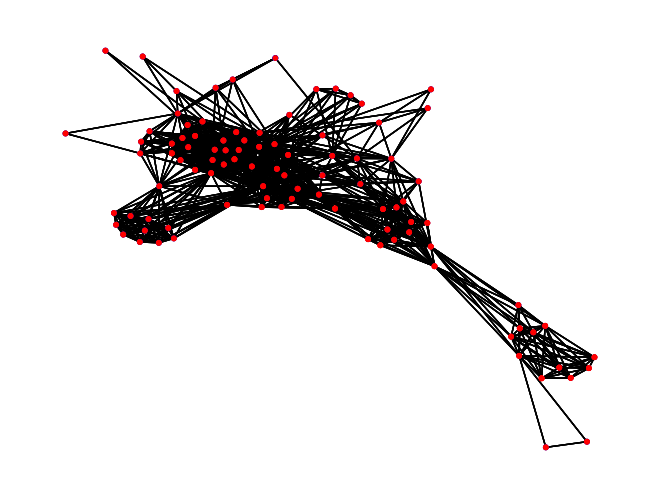

In [48]:
import random
from matplotlib import pyplot as plt, animation
import glob
import os
iteration=[]
amount=[]
def cascade(G,starts,show):
    Visited=[]
    next=[]
    color_map=[]
    spreading_curve=[]
    pos = nx.spring_layout(G, seed=41)
    def nextNode(G):
        target=[]
        for j in range (len(next)):
            neighbors = list(nx.neighbors(G,next[j]))
            for i in range(len(neighbors)):
                if neighbors[i] not in target and neighbors[i] not in Visited:
                    target.append(neighbors[i])
        
        next.clear()
        next.extend(target)
        Visited.extend(next)
    
    def ShowGraph(G,i):
        
        ##print(next)
        color_map.clear()
        for node in G:
            if node in Visited:
                color_map.append('red')
            else: 
                color_map.append('blue')  
                
        nx.draw(G,pos=pos,node_color=color_map,node_size=10)
        imageName = "images/"+str(i)
        plt.savefig(imageName)
        
        
    def truncate(path):
        files = glob.glob(path+'/*.*')
        for f in files:
            os.remove(f)
    
    Visited.extend(starts)
    next.extend(starts)
    
    i=1
    truncate("images")
    while (True):
        
        spreading_curve.append(len(Visited))
        if(show==True):
            ShowGraph(G,i)
        i=i+1
        nextNode(G)
        
        
        if (len(next) == 0):
            break
        #input("Press Enter to continue...")
        
    return spreading_curve        
    
    

spreading_curve = cascade(graph_net,random.sample(range(0, nx.number_of_nodes(graph_net)),5),True)
plt.show()

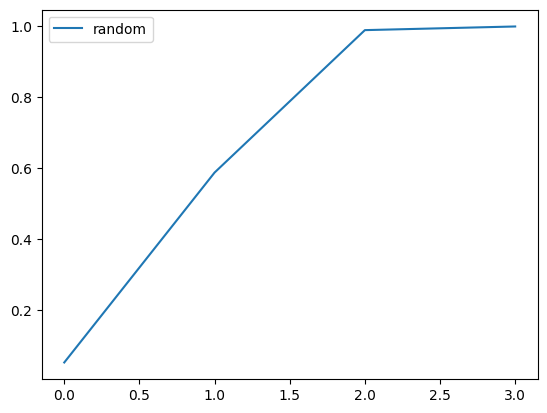

In [49]:
def plotSpreadingCurve(spreading_curve, title):
    for i in range (len(spreading_curve)):
        spreading_curve[i]=spreading_curve[i]/97
    plt.plot(spreading_curve,label=title)
    plt.legend()
    
plotSpreadingCurve(spreading_curve, "random")

In [50]:
import glob
from PIL import Image

# filepaths
fp_in = "images/*.png"
fp_out = "gif.gif"


imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)


![my_awesome.gif](gif.gif)




In [51]:
import time
all_nodes = graph_net.nodes
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=85):
    total_spead = 0
    
    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i+10)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = set(graph_net.neighbors(node))
                success = np.random.uniform(0, 1) < prob
                activated_nodes += list(np.extract(success, list(neighbors)))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list

            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)

    return total_spead / n_iters

def greedy(graph, k, prob, n_iters):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information

    elapsed = []
    spreads = []
    solution = []
    start_time = time.time()
    
    for _ in range(k):
        best_node = -1
        best_spread = -np.inf
        
        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        
        for node in all_nodes:
            spread = compute_independent_cascade(graph, solution + [node], prob, n_iters)
            if spread > best_spread:
                best_spread = spread
                best_node = node
                
        solution.append(best_node)
        spreads.append(best_spread)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return solution, spreads, elapsed
seed_nodes = [0]
prob = 0.11
n_iters = 1000
greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph_net, 5, prob, n_iters)
print('solution: ', greedy_solution)
print('spreads: ', greedy_spreads)
print('elapsed: ', greedy_elapsed)

solution:  [14, 3, 30, 89, 25]
spreads:  [1.138, 2.253, 3.377, 4.498, 5.605]
elapsed:  [4.001, 11.15, 21.66, 33.28, 50.042]


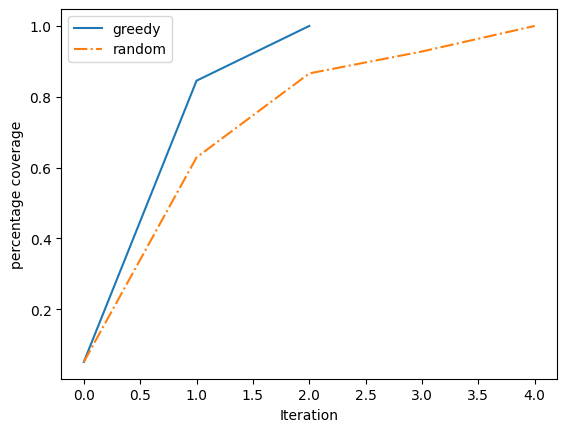

In [52]:

SC = cascade(graph_net, [14, 3, 30, 89, 25],False)
for i in range (len(SC)):
    SC[i]=SC[i]/97

plt.plot(SC,label="greedy")

spreading_curve = cascade(graph_net,random.sample(range(0, nx.number_of_nodes(graph_net)), 5),False)
for j in range (len(spreading_curve)):
    spreading_curve[j]=spreading_curve[j]/97
plt.plot(spreading_curve,'-.',label="random")

    
for i in range (0):
    spreading_curve = cascade(graph_net,random.sample(range(0, nx.number_of_nodes(graph_net)), 5),False)
    for j in range (len(spreading_curve)):
        spreading_curve[j]=spreading_curve[j]/97
    plt.plot(spreading_curve,'-.')

plt.legend()
plt.ylabel('percentage coverage')
plt.xlabel("Iteration")
plt.show()



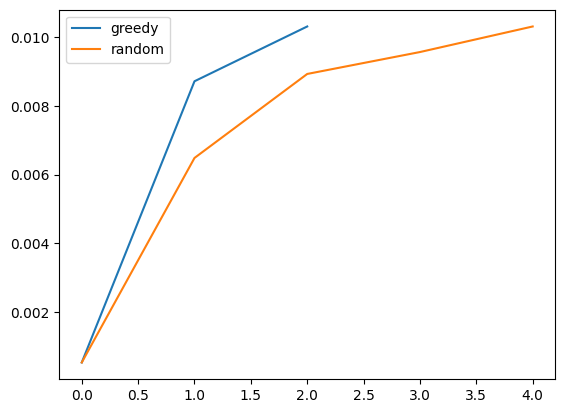

In [53]:
plotSpreadingCurve(SC, "greedy")
plotSpreadingCurve(spreading_curve, "random")

97
1360
[14, 3, 30, 89, 25]


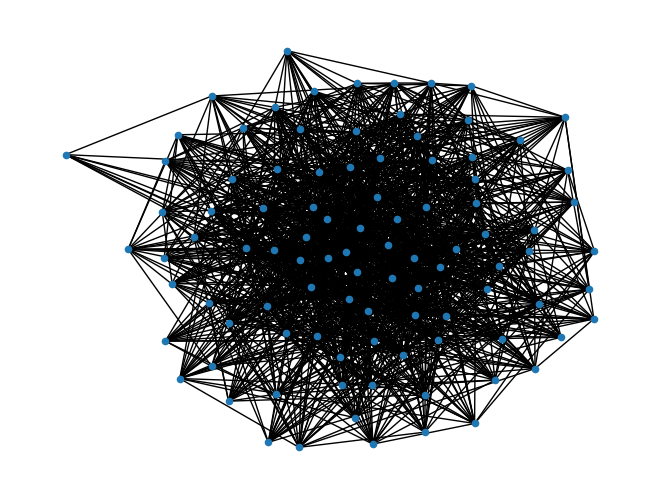

In [54]:
def Barabasi_Albert(G):
    BA = nx.barabasi_albert_graph(nx.number_of_nodes(G), 17)
    nx.draw(BA,node_size=20)
    return BA

BA =Barabasi_Albert(graph_net)
print(nx.number_of_nodes(BA))
print(nx.number_of_edges(BA))


BA_greedy_solution, greedy_spreads, greedy_elapsed = greedy(BA, 5, prob, 1000)
print(BA_greedy_solution)



In [55]:
spreading_curve = cascade(BA,random.sample(range(0, nx.number_of_nodes(BA)), 5),False)
SC = cascade(BA, [14, 3, 30, 89, 25],False)


[5, 81, 97]
[5, 81, 97]


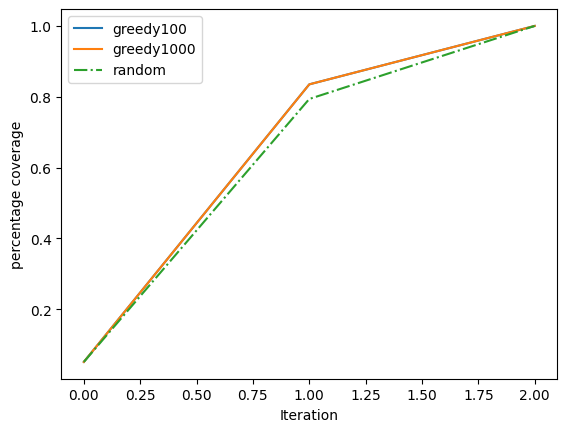

In [59]:
SC = cascade(BA, [14, 3, 30, 89, 25],False)
print(SC)
for i in range (len(SC)):
    SC[i]=SC[i]/97
plt.plot(SC,label="greedy100")


SC1 = cascade(BA, [14, 30, 89, 25, 3],False)
print(SC1)
for i in range (len(SC1)):
    SC1[i]=SC1[i]/97
plt.plot(SC1,label="greedy1000")

spreading_curve = cascade(BA,random.sample(range(0, nx.number_of_nodes(BA)), 5),False)
for j in range (len(spreading_curve)):
    spreading_curve[j]=spreading_curve[j]/97
plt.plot(spreading_curve,'-.',label="random")
    
for i in range (0):
    spreading_curve = cascade(BA,random.sample(range(0, nx.number_of_nodes(BA)), 5),False)
    for j in range (len(spreading_curve)):
        spreading_curve[j]=spreading_curve[j]/97
    plt.plot(spreading_curve,'-.')
    
    
plt.legend()
plt.ylabel('percentage coverage')
plt.xlabel("Iteration")
plt.show()

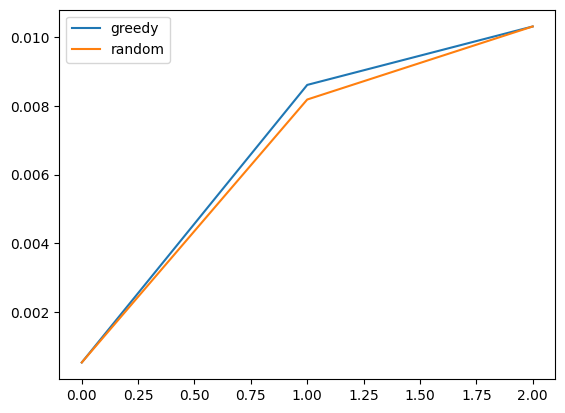

In [60]:
plotSpreadingCurve(SC, "greedy")
plotSpreadingCurve(spreading_curve, "random")